In [1]:
import glob
import os
# import librosa
# from librosa import display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
features = np.loadtxt('nn_simple_features.csv', delimiter=',')
labels = np.array(np.loadtxt('nn_simple_labels.csv', delimiter=','), dtype=np.int)

In [3]:
from sklearn.preprocessing import normalize

X_all = features
y_all = labels

In [4]:
from sklearn.model_selection import train_test_split
import time

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, stratify=y_all, train_size=.8, random_state=round(time.time()))

# X_train, X_val, y_train, y_val = train_test_split(
#     X_not_test, y_not_rest, stratify=y_not_rest, train_size=.85, random_state=round(time.time()))

print(X_train.shape)
print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(9460, 1280)
(9460, 5)
(2366, 1280)
(2366, 5)


/home/hitmann/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
# Parameters
# learning_rate = 0.005

with tf.name_scope("learning_rate"):
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.005
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               75, 0.99, staircase=True)
    tf.summary.scalar("learning_rate", learning_rate)

epochs = 40
batch_size = 32

# Network Parameters
n_input = 40 * 32
n_classes = 5
dropout = .8 # Dropout, probability to keep units

# 1. Define Variables and Placeholders
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

def build_model(x, dropout, activation):
    
    x = tf.reshape(x, shape=[-1, 40, 32, 1])
    
    conv1 = tf.layers.conv2d(x, 4, 5, activation=activation)
    conv1 = tf.layers.batch_normalization(conv1)
    conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
    conv1 = tf.nn.dropout(conv1, dropout)
    
    conv2 = tf.layers.conv2d(conv1, 8, 3, activation=activation)
    conv2 = tf.layers.batch_normalization(conv2)
    conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
    conv2 = tf.nn.dropout(conv2, dropout)
    
    fc1 = tf.contrib.layers.flatten(conv2)

    fc1 = tf.layers.dense(fc1, 128, activation=activation)
    fc1 = tf.layers.batch_normalization(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    fc2 = tf.layers.dense(fc1, 64, activation=activation)
    fc2 = tf.layers.batch_normalization(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    out = tf.layers.dense(fc2, n_classes)

    return out

predictions = build_model(x, keep_prob, activation=tf.nn.relu)
# 3. Define the loss function
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y), name='loss')
    tf.summary.scalar("loss", loss)
    

# 4. Define the accuracy 
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

summary = tf.summary.merge_all()
# 5. Define an optimizer
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss, global_step=global_step)

def feed_next_batch(train_size, batch_size=64):
    
    start = 0
    while start < train_size:
        yield start, start + batch_size
        start += batch_size

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

RUN_NAME = 'tf_on_gpu_train_test_split'
writer_train = tf.summary.FileWriter('./log/' + RUN_NAME + '/train', graph=sess.graph)
writer_test = tf.summary.FileWriter('./log/' + RUN_NAME + '/test', graph=sess.graph)

steps = 0
# Keep training until reach max iterations
for epoch in range(epochs):

    indices = np.arange(len(y_train))
    np.random.shuffle(indices)
    X_train, y_train =  X_train[indices], y_train[indices]

    for start, end in feed_next_batch(len(X_train), batch_size=batch_size):
        # Run optimization op (backprop)
        batch_x, batch_y = X_train[start:end], y_train[start:end]
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        
        steps += 1
        
        if steps % 20 == 0:

            # Calculate batch loss and accuracy
            train_loss, train_acc, train_lr, summary_train = sess.run([loss, accuracy, learning_rate, summary], 
                                                   feed_dict={x: X_train, y: y_train, keep_prob: 1.0})
            writer_train.add_summary(summary_train, steps)

            print('Step %d' % (steps))
            print('learning_rate:', train_lr)
            print ("Training loss:", train_loss, ', Training acc: ', train_acc)

            val_loss, val_acc, summary_test = sess.run([loss, accuracy, summary], feed_dict={x: X_test, 
                                                                        y: y_test,
                                                                       keep_prob: 1.0})
            writer_test.add_summary(summary_test, steps)
            print ("Test loss:", val_loss, ', Test acc: ', val_acc)
            print('-' * 80)

print ("Optimization Finished!")

# Calculate accuracy for all test samples
print ("Training Accuracy:", \
    sess.run(accuracy, feed_dict={x: X_train,
                                  y: y_train,
                                 keep_prob: 1.0}))
print ("Test Accuracy:", \
    sess.run(accuracy, feed_dict={x: X_test,
                                  y: y_test,
                                 keep_prob: 1.0}))

Step 20
learning_rate: 0.005
Training loss: 1.63625 , Training acc:  0.216702
Test loss: 1.63692 , Test acc:  0.20541
--------------------------------------------------------------------------------
Step 40
learning_rate: 0.005
Training loss: 1.6236 , Training acc:  0.202537
Test loss: 1.62126 , Test acc:  0.194844
--------------------------------------------------------------------------------
Step 60
learning_rate: 0.005
Training loss: 1.61146 , Training acc:  0.204228
Test loss: 1.61195 , Test acc:  0.201183
--------------------------------------------------------------------------------
Step 80
learning_rate: 0.00495
Training loss: 1.6085 , Training acc:  0.206554
Test loss: 1.60909 , Test acc:  0.20541
--------------------------------------------------------------------------------
Step 100
learning_rate: 0.00495
Training loss: 1.6021 , Training acc:  0.237949
Test loss: 1.60263 , Test acc:  0.228233
--------------------------------------------------------------------------------


Step 820
learning_rate: 0.00452191
Training loss: 0.806072 , Training acc:  0.702114
Test loss: 0.821162 , Test acc:  0.688504
--------------------------------------------------------------------------------
Step 840
learning_rate: 0.00447669
Training loss: 0.746561 , Training acc:  0.732135
Test loss: 0.761175 , Test acc:  0.726965
--------------------------------------------------------------------------------
Step 860
learning_rate: 0.00447669
Training loss: 0.738066 , Training acc:  0.735412
Test loss: 0.759937 , Test acc:  0.729924
--------------------------------------------------------------------------------
Step 880
learning_rate: 0.00447669
Training loss: 0.782335 , Training acc:  0.713002
Test loss: 0.789441 , Test acc:  0.701606
--------------------------------------------------------------------------------
Step 900
learning_rate: 0.00443192
Training loss: 0.709617 , Training acc:  0.741015
Test loss: 0.728568 , Test acc:  0.732882
-----------------------------------------

Step 1620
learning_rate: 0.00404864
Training loss: 0.557934 , Training acc:  0.790381
Test loss: 0.605187 , Test acc:  0.764582
--------------------------------------------------------------------------------
Step 1640
learning_rate: 0.00404864
Training loss: 0.520223 , Training acc:  0.812685
Test loss: 0.570538 , Test acc:  0.800085
--------------------------------------------------------------------------------
Step 1660
learning_rate: 0.00400815
Training loss: 0.50759 , Training acc:  0.826427
Test loss: 0.547289 , Test acc:  0.814455
--------------------------------------------------------------------------------
Step 1680
learning_rate: 0.00400815
Training loss: 0.644831 , Training acc:  0.763636
Test loss: 0.687979 , Test acc:  0.745985
--------------------------------------------------------------------------------
Step 1700
learning_rate: 0.00400815
Training loss: 0.510923 , Training acc:  0.819027
Test loss: 0.553426 , Test acc:  0.804734
-------------------------------------

Step 2420
learning_rate: 0.0036249
Training loss: 0.400433 , Training acc:  0.86945
Test loss: 0.454099 , Test acc:  0.844463
--------------------------------------------------------------------------------
Step 2440
learning_rate: 0.0036249
Training loss: 0.420239 , Training acc:  0.859514
Test loss: 0.479157 , Test acc:  0.83432
--------------------------------------------------------------------------------
Step 2460
learning_rate: 0.0036249
Training loss: 0.43552 , Training acc:  0.842178
Test loss: 0.481919 , Test acc:  0.828825
--------------------------------------------------------------------------------
Step 2480
learning_rate: 0.00358865
Training loss: 0.386599 , Training acc:  0.866173
Test loss: 0.441375 , Test acc:  0.844463
--------------------------------------------------------------------------------
Step 2500
learning_rate: 0.00358865
Training loss: 0.400215 , Training acc:  0.863636
Test loss: 0.459854 , Test acc:  0.838546
------------------------------------------

Step 3220
learning_rate: 0.0032783
Training loss: 0.337421 , Training acc:  0.891226
Test loss: 0.411143 , Test acc:  0.85672
--------------------------------------------------------------------------------
Step 3240
learning_rate: 0.00324551
Training loss: 0.286892 , Training acc:  0.905497
Test loss: 0.349123 , Test acc:  0.87109
--------------------------------------------------------------------------------
Step 3260
learning_rate: 0.00324551
Training loss: 0.329975 , Training acc:  0.8963
Test loss: 0.401588 , Test acc:  0.863483
--------------------------------------------------------------------------------
Step 3280
learning_rate: 0.00324551
Training loss: 0.332315 , Training acc:  0.884567
Test loss: 0.399381 , Test acc:  0.857143
--------------------------------------------------------------------------------
Step 3300
learning_rate: 0.00321306
Training loss: 0.310175 , Training acc:  0.893235
Test loss: 0.385774 , Test acc:  0.864328
-----------------------------------------

Step 4020
learning_rate: 0.00293519
Training loss: 0.244103 , Training acc:  0.919028
Test loss: 0.326432 , Test acc:  0.881234
--------------------------------------------------------------------------------
Step 4040
learning_rate: 0.00293519
Training loss: 0.242637 , Training acc:  0.917019
Test loss: 0.321173 , Test acc:  0.881234
--------------------------------------------------------------------------------
Step 4060
learning_rate: 0.00290583
Training loss: 0.235542 , Training acc:  0.923256
Test loss: 0.308768 , Test acc:  0.896027
--------------------------------------------------------------------------------
Step 4080
learning_rate: 0.00290583
Training loss: 0.224404 , Training acc:  0.929175
Test loss: 0.310572 , Test acc:  0.888842
--------------------------------------------------------------------------------
Step 4100
learning_rate: 0.00290583
Training loss: 0.26929 , Training acc:  0.909725
Test loss: 0.351801 , Test acc:  0.880812
-------------------------------------

Step 4820
learning_rate: 0.00262798
Training loss: 0.173963 , Training acc:  0.944609
Test loss: 0.269779 , Test acc:  0.902367
--------------------------------------------------------------------------------
Step 4840
learning_rate: 0.00262798
Training loss: 0.208332 , Training acc:  0.932981
Test loss: 0.298573 , Test acc:  0.897295
--------------------------------------------------------------------------------
Step 4860
learning_rate: 0.00262798
Training loss: 0.179093 , Training acc:  0.944715
Test loss: 0.277249 , Test acc:  0.907439
--------------------------------------------------------------------------------
Step 4880
learning_rate: 0.0026017
Training loss: 0.175089 , Training acc:  0.944503
Test loss: 0.271665 , Test acc:  0.906171
--------------------------------------------------------------------------------
Step 4900
learning_rate: 0.0026017
Training loss: 0.190102 , Training acc:  0.939112
Test loss: 0.278614 , Test acc:  0.900254
--------------------------------------

Step 5620
learning_rate: 0.0023767
Training loss: 0.155643 , Training acc:  0.950846
Test loss: 0.265489 , Test acc:  0.902367
--------------------------------------------------------------------------------
Step 5640
learning_rate: 0.00235293
Training loss: 0.178187 , Training acc:  0.943658
Test loss: 0.29639 , Test acc:  0.895182
--------------------------------------------------------------------------------
Step 5660
learning_rate: 0.00235293
Training loss: 0.161007 , Training acc:  0.950634
Test loss: 0.283073 , Test acc:  0.890955
--------------------------------------------------------------------------------
Step 5680
learning_rate: 0.00235293
Training loss: 0.14927 , Training acc:  0.959091
Test loss: 0.261668 , Test acc:  0.906593
--------------------------------------------------------------------------------
Step 5700
learning_rate: 0.00232941
Training loss: 0.160539 , Training acc:  0.948097
Test loss: 0.280528 , Test acc:  0.894336
---------------------------------------

Step 6420
learning_rate: 0.00212795
Training loss: 0.157355 , Training acc:  0.946723
Test loss: 0.301446 , Test acc:  0.893914
--------------------------------------------------------------------------------
Step 6440
learning_rate: 0.00212795
Training loss: 0.116289 , Training acc:  0.961945
Test loss: 0.253496 , Test acc:  0.907016
--------------------------------------------------------------------------------
Step 6460
learning_rate: 0.00210667
Training loss: 0.119412 , Training acc:  0.960994
Test loss: 0.248434 , Test acc:  0.909975
--------------------------------------------------------------------------------
Step 6480
learning_rate: 0.00210667
Training loss: 0.128828 , Training acc:  0.962791
Test loss: 0.261666 , Test acc:  0.901944
--------------------------------------------------------------------------------
Step 6500
learning_rate: 0.00210667
Training loss: 0.117036 , Training acc:  0.965011
Test loss: 0.245197 , Test acc:  0.907861
------------------------------------

Step 7220
learning_rate: 0.00190524
Training loss: 0.114756 , Training acc:  0.965433
Test loss: 0.25142 , Test acc:  0.911665
--------------------------------------------------------------------------------
Step 7240
learning_rate: 0.00190524
Training loss: 0.0973236 , Training acc:  0.972939
Test loss: 0.231798 , Test acc:  0.916314
--------------------------------------------------------------------------------
Step 7260
learning_rate: 0.00190524
Training loss: 0.101064 , Training acc:  0.971142
Test loss: 0.238367 , Test acc:  0.915892
--------------------------------------------------------------------------------
Step 7280
learning_rate: 0.00188618
Training loss: 0.0986043 , Training acc:  0.971036
Test loss: 0.238419 , Test acc:  0.91716
--------------------------------------------------------------------------------
Step 7300
learning_rate: 0.00188618
Training loss: 0.108511 , Training acc:  0.966808
Test loss: 0.244976 , Test acc:  0.909975
------------------------------------

Step 8020
learning_rate: 0.00172306
Training loss: 0.0940504 , Training acc:  0.97389
Test loss: 0.232209 , Test acc:  0.919273
--------------------------------------------------------------------------------
Step 8040
learning_rate: 0.00170583
Training loss: 0.103316 , Training acc:  0.972304
Test loss: 0.240501 , Test acc:  0.915469
--------------------------------------------------------------------------------
Step 8060
learning_rate: 0.00170583
Training loss: 0.0972338 , Training acc:  0.975053
Test loss: 0.237087 , Test acc:  0.91716
--------------------------------------------------------------------------------
Step 8080
learning_rate: 0.00170583
Training loss: 0.097185 , Training acc:  0.974101
Test loss: 0.240397 , Test acc:  0.91716
--------------------------------------------------------------------------------
Step 8100
learning_rate: 0.00168877
Training loss: 0.0871191 , Training acc:  0.974841
Test loss: 0.231404 , Test acc:  0.914201
------------------------------------

Step 8820
learning_rate: 0.00154272
Training loss: 0.0842464 , Training acc:  0.978013
Test loss: 0.236726 , Test acc:  0.915892
--------------------------------------------------------------------------------
Step 8840
learning_rate: 0.00154272
Training loss: 0.0791956 , Training acc:  0.979387
Test loss: 0.230789 , Test acc:  0.914624
--------------------------------------------------------------------------------
Step 8860
learning_rate: 0.0015273
Training loss: 0.0766295 , Training acc:  0.98055
Test loss: 0.227139 , Test acc:  0.915892
--------------------------------------------------------------------------------
Step 8880
learning_rate: 0.0015273
Training loss: 0.0848611 , Training acc:  0.97833
Test loss: 0.236381 , Test acc:  0.913356
--------------------------------------------------------------------------------
Step 8900
learning_rate: 0.0015273
Training loss: 0.0832425 , Training acc:  0.978647
Test loss: 0.237336 , Test acc:  0.912088
------------------------------------

Step 9620
learning_rate: 0.00138126
Training loss: 0.075377 , Training acc:  0.979598
Test loss: 0.233511 , Test acc:  0.914201
--------------------------------------------------------------------------------
Step 9640
learning_rate: 0.00138126
Training loss: 0.0654789 , Training acc:  0.984778
Test loss: 0.219912 , Test acc:  0.923077
--------------------------------------------------------------------------------
Step 9660
learning_rate: 0.00138126
Training loss: 0.0658214 , Training acc:  0.985095
Test loss: 0.221545 , Test acc:  0.918428
--------------------------------------------------------------------------------
Step 9680
learning_rate: 0.00136745
Training loss: 0.0708021 , Training acc:  0.981078
Test loss: 0.230476 , Test acc:  0.916737
--------------------------------------------------------------------------------
Step 9700
learning_rate: 0.00136745
Training loss: 0.0676826 , Training acc:  0.982241
Test loss: 0.230532 , Test acc:  0.916314
--------------------------------

Step 10420
learning_rate: 0.00124919
Training loss: 0.0608904 , Training acc:  0.986786
Test loss: 0.21521 , Test acc:  0.9235
--------------------------------------------------------------------------------
Step 10440
learning_rate: 0.00123669
Training loss: 0.0802054 , Training acc:  0.978541
Test loss: 0.240139 , Test acc:  0.91716
--------------------------------------------------------------------------------
Step 10460
learning_rate: 0.00123669
Training loss: 0.0635391 , Training acc:  0.983721
Test loss: 0.222375 , Test acc:  0.920964
--------------------------------------------------------------------------------
Step 10480
learning_rate: 0.00123669
Training loss: 0.0586366 , Training acc:  0.986152
Test loss: 0.216387 , Test acc:  0.922232
--------------------------------------------------------------------------------
Step 10500
learning_rate: 0.00122433
Training loss: 0.0650791 , Training acc:  0.983615
Test loss: 0.227551 , Test acc:  0.921809
------------------------------

Step 11200
learning_rate: 0.00111844
Training loss: 0.0547472 , Training acc:  0.987738
Test loss: 0.219146 , Test acc:  0.928149
--------------------------------------------------------------------------------
Step 11220
learning_rate: 0.00111844
Training loss: 0.0497111 , Training acc:  0.988689
Test loss: 0.218854 , Test acc:  0.927303
--------------------------------------------------------------------------------
Step 11240
learning_rate: 0.00111844
Training loss: 0.0549991 , Training acc:  0.986364
Test loss: 0.22531 , Test acc:  0.921809
--------------------------------------------------------------------------------
Step 11260
learning_rate: 0.00110726
Training loss: 0.0510401 , Training acc:  0.987844
Test loss: 0.21802 , Test acc:  0.923922
--------------------------------------------------------------------------------
Step 11280
learning_rate: 0.00110726
Training loss: 0.0517553 , Training acc:  0.986786
Test loss: 0.227158 , Test acc:  0.922654
----------------------------

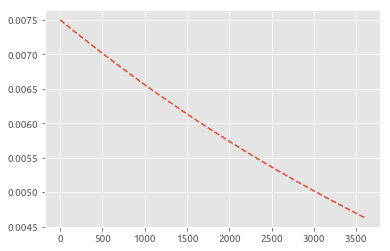

In [7]:
sess.close()

arr5 = np.arange(0, 3600)
arr5 = 0.0075 * 0.99 ** (arr5/75)
plt.plot(arr5, '--'),
plt.show()